In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, davies_bouldin_score

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram



In [2]:
df = pd.read_csv('gym_churn_us.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
df.columns = df.columns.str.lower()
print(df.columns)

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')


In [5]:
df.head(10)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


# EDA

In [6]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [7]:
df.churn.value_counts()


churn
0    2939
1    1061
Name: count, dtype: int64

In [8]:
df_group = df.groupby('churn').mean()
df_group.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


<function matplotlib.pyplot.show(close=None, block=None)>

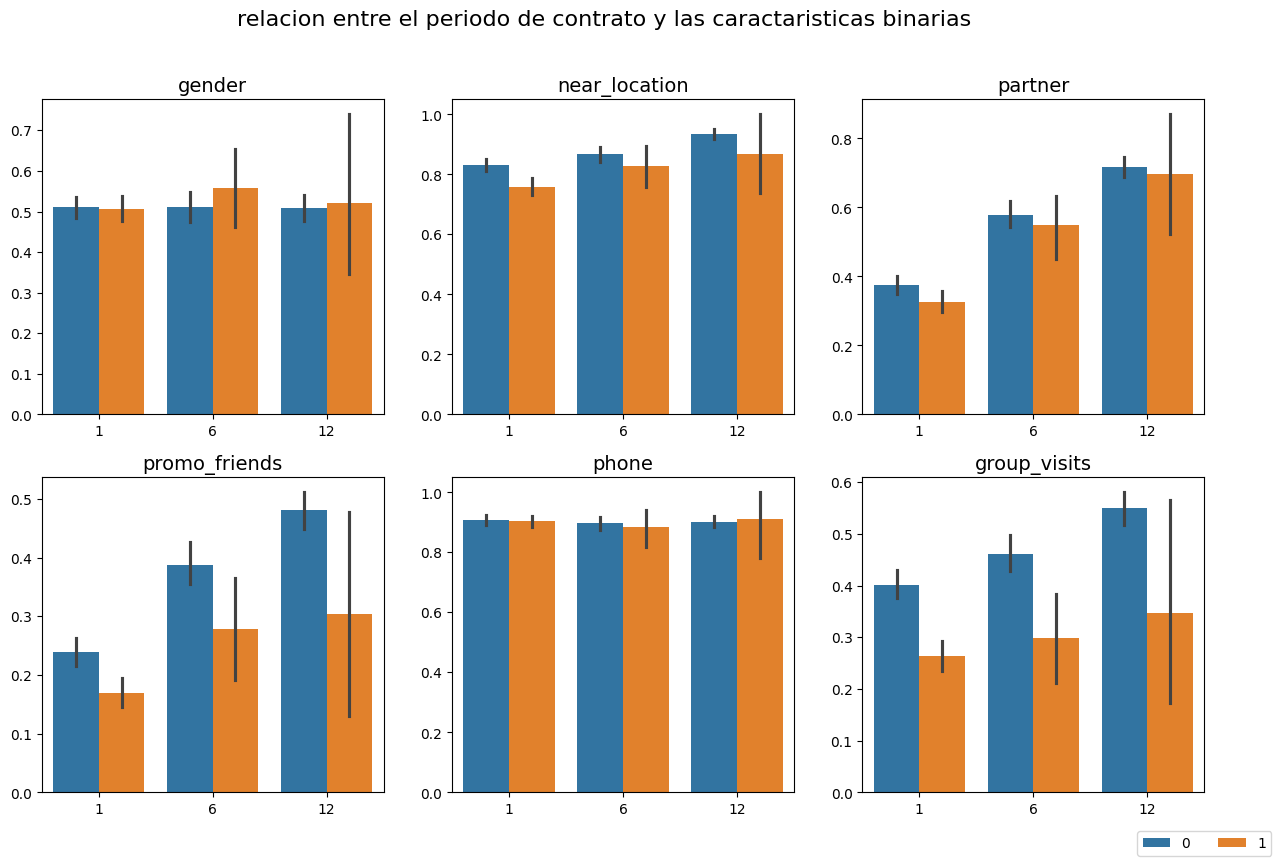

In [9]:
columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,9))
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        sns.barplot(x='contract_period', y=columns[i], data=df, hue='churn', ax=ax)
        ax.legend([], [], frameon=False)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(f'{columns[i]}', fontsize=14)
    else:
        ax.axis('off')

plt.legend(loc='upper center', bbox_to_anchor=(1, -0.1), ncol=2, frameon=True)

fig.suptitle('relacion entre el periodo de contrato y las caractaristicas binarias', fontsize=16)
fig.subplots_adjust(top=0.88)
plt.show

C:\Users\supercash\AppData\Local\Temp\ipykernel_15048\508653119.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper center', bbox_to_anchor=(1, -0.1), ncol=2, frameon=True)


<function matplotlib.pyplot.show(close=None, block=None)>

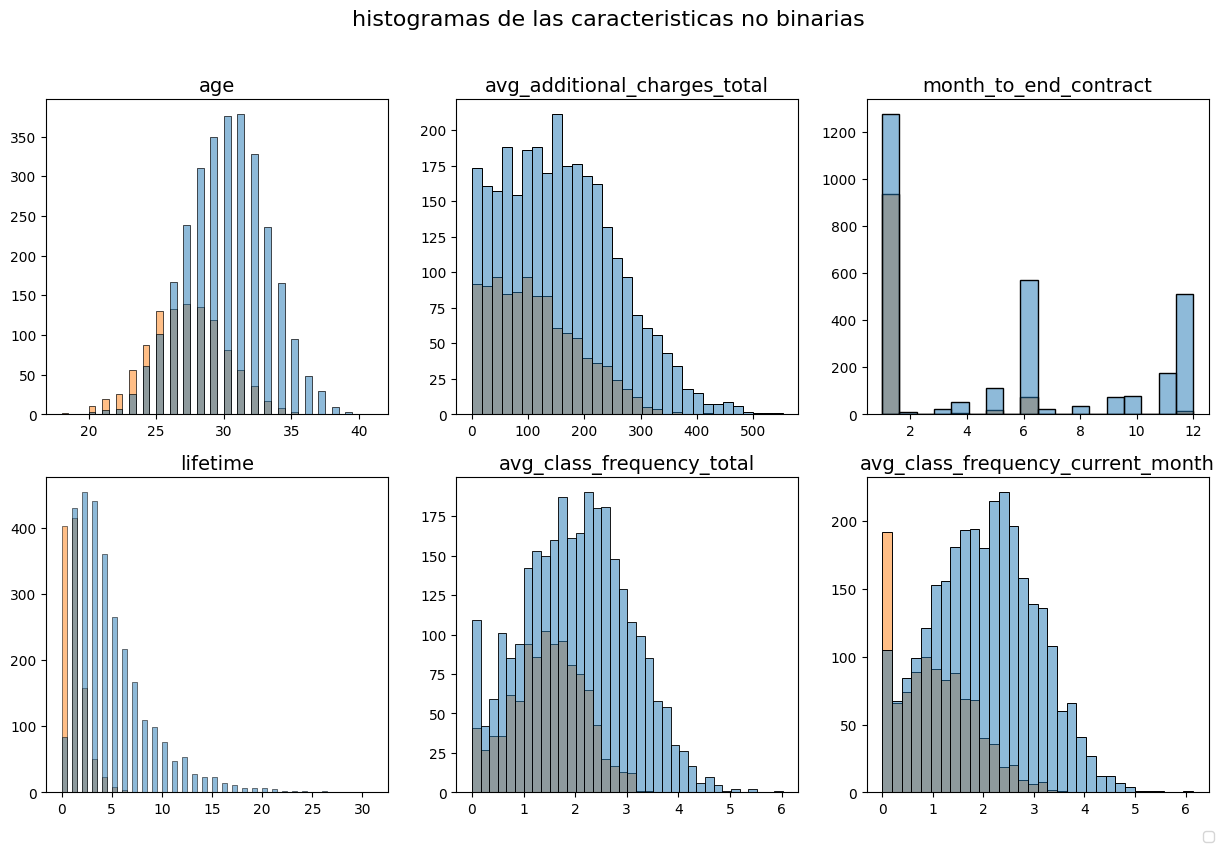

In [10]:
columns = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,9))
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        sns.histplot(x=columns[i], data=df, hue='churn', ax=ax)
        ax.legend([], [], frameon=False)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(f'{columns[i]}', fontsize=14)
    else:
        ax.axis('off')

plt.legend(loc='upper center', bbox_to_anchor=(1, -0.1), ncol=2, frameon=True)

fig.suptitle('histogramas de las caracteristicas no binarias', fontsize=16)
fig.subplots_adjust(top=0.88)
plt.show    

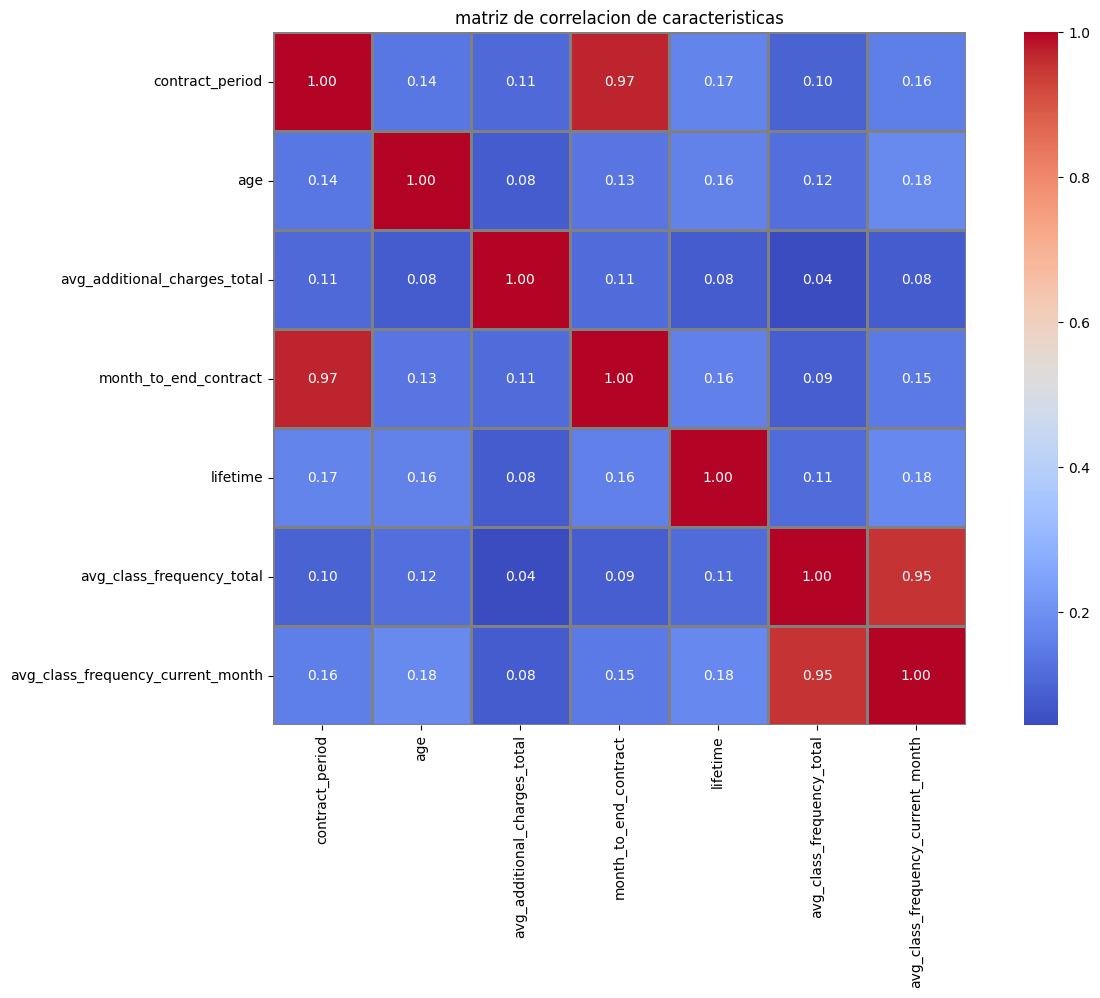

In [11]:
col_cuant = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
df_col_cuant = df[col_cuant]
corr = df_col_cuant.corr()
plt.figure(figsize=(15, 9 ))
plt.title('matriz de correlacion de caracteristicas')
sns.heatmap(corr, fmt='.2f', annot=True, square=True, linewidths=1, linecolor='grey', cmap='coolwarm')
plt.show(block=False)

In [12]:
col_cat = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

cat_tables = []
for col in col_cat:
    cat_table = pd.crosstab(index=df[col], columns=df['churn'], normalize='index')
    cat_tables.append(cat_table)

In [13]:
cat_tables

[churn          0         1
 gender                    
 0       0.735069  0.264931
 1       0.734444  0.265556,
 churn                 0         1
 near_location                    
 0              0.602585  0.397415
 1              0.758947  0.241053,
 churn           0         1
 partner                    
 0        0.666829  0.333171
 1        0.806369  0.193631,
 churn                 0         1
 promo_friends                    
 0              0.686913  0.313087
 1              0.841977  0.158023,
 churn         0         1
 phone                    
 0      0.733161  0.266839
 1      0.734920  0.265080,
 churn                0         1
 group_visits                    
 0             0.669928  0.330072
 1             0.827168  0.172832]

<function matplotlib.pyplot.show(close=None, block=None)>

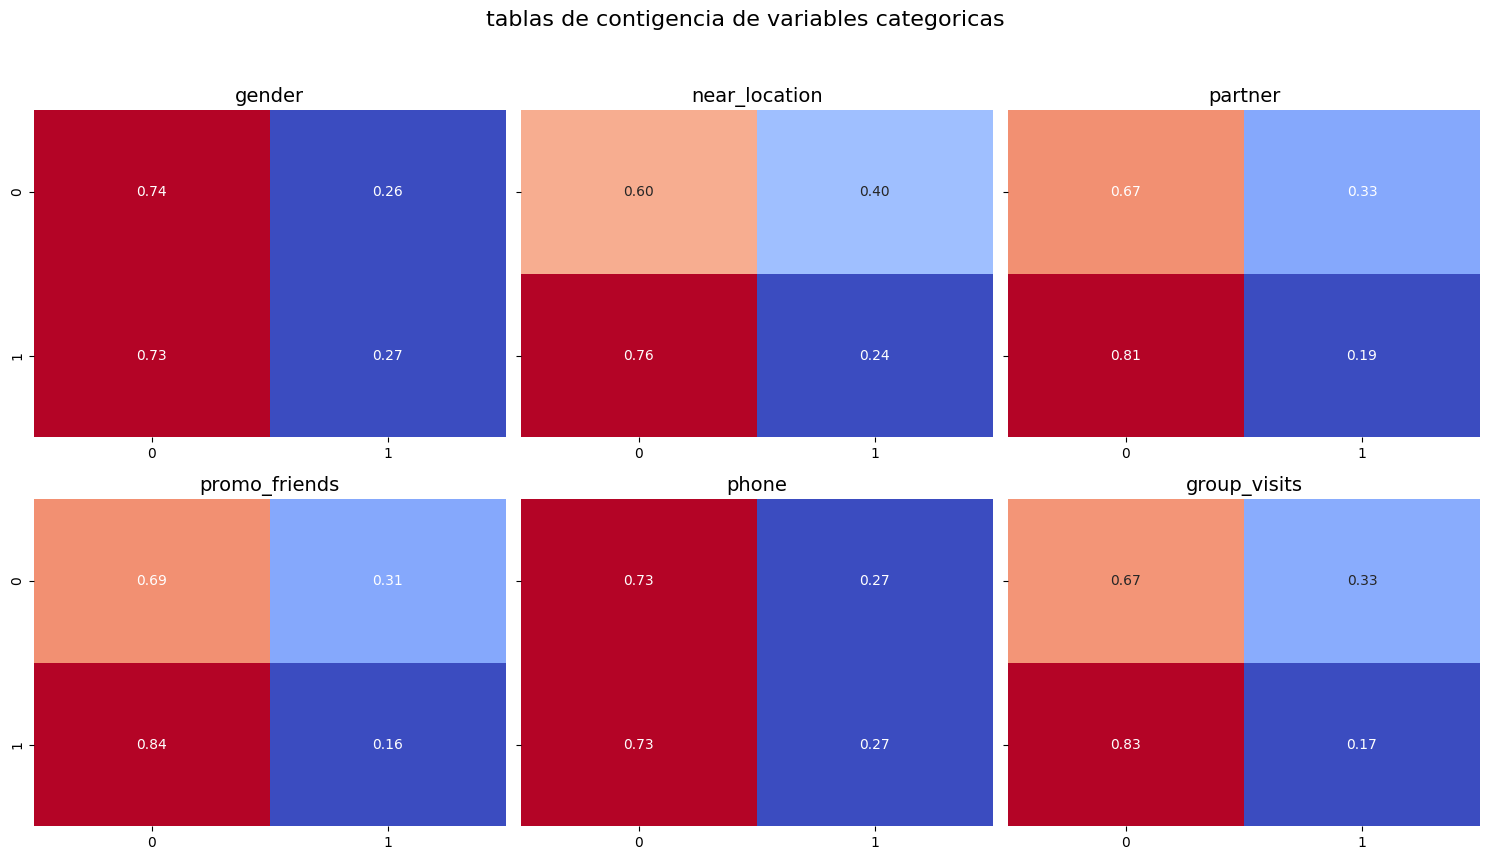

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,9), sharey=True)
fig.suptitle('tablas de contigencia de variables categoricas', fontsize=16)

for i, ax in enumerate(axs.flat):
    if i < len(cat_tables):
        sns.heatmap(cat_tables[i], annot=True, fmt='.2f', cmap='coolwarm', cbar=False, ax=ax)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(f'{col_cat[i]}', fontsize=14)
    else:
        ax.axis('off')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show    

# Modelo de Prediccion

In [15]:
X = df.drop(['gender', 'phone', 'month_to_end_contract', 'avg_class_frequency_total', 'churn'], axis=1)
y =df['churn']

In [16]:
X

,near_location,partner,promo_friends,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month
0,1,1,1,6,1,29,14.227470,3,0.000000
1,1,0,0,12,1,31,113.202938,7,1.910244
2,1,1,0,1,0,28,129.448479,2,1.736502
3,1,1,1,12,1,33,62.669863,2,3.357215
4,1,1,1,1,0,26,198.362265,3,1.120078
...,...,...,...,...,...,...,...,...,...
3995,1,1,0,12,0,33,2.406023,8,2.349070
3996,1,0,0,1,1,29,68.883764,1,0.292859
3997,1,1,1,12,0,28,78.250542,2,2.831439
3998,1,1,1,6,0,32,61.912657,3,1.596237


In [17]:
y

0       0
1       0
2       0
3       0
4       0
       ..
3995    0
3996    1
3997    0
3998    0
3999    0
Name: churn, Length: 4000, dtype: int64

In [18]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2,  random_state=5858)

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
model_lr = LogisticRegression(random_state=5858, class_weight='balanced') 
model_lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=5858)

In [21]:
pred_lr = model_lr.predict(X_test)

In [22]:
pred_lr

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,

In [23]:
pred_lr_proba = model_lr.predict_proba(X_test)[:,1]

In [24]:
pred_lr_proba

array([9.63214277e-01, 6.23407241e-02, 4.55667834e-04, 1.60110515e-02,
       5.95821609e-02, 1.44748791e-01, 5.22655278e-01, 8.08152374e-01,
       9.97938473e-01, 2.87067981e-03, 6.92090654e-01, 1.03982427e-01,
       7.67314611e-01, 1.24392074e-02, 1.59902053e-06, 2.68353539e-03,
       1.23175728e-02, 9.99155952e-01, 3.34697651e-05, 8.82954106e-01,
       7.23480668e-01, 9.91442183e-01, 9.32027461e-01, 5.71791884e-03,
       1.77262200e-01, 5.71725215e-02, 3.86743359e-03, 3.05693220e-01,
       9.82660996e-01, 2.23270299e-03, 9.63785287e-01, 4.93462784e-03,
       3.41669761e-04, 4.16628560e-01, 3.23158293e-03, 8.59765180e-04,
       2.12353189e-02, 3.84668420e-02, 7.13240998e-03, 9.95629784e-01,
       6.57236368e-02, 3.16479316e-03, 2.32010513e-01, 5.49131457e-05,
       5.49662440e-05, 1.08506293e-03, 3.63537242e-03, 9.77720953e-01,
       4.78549685e-01, 7.64918603e-04, 2.19640530e-03, 1.17842756e-04,
       1.73983986e-07, 1.53695787e-01, 4.85996452e-02, 2.82276546e-03,
      

In [25]:
model_rfc = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=5858)
model_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=5858)

In [26]:
pred_rfc = model_rfc.predict(X_test)
pred_rfc_proba = model_rfc.predict_proba(X_test)[:,1]

In [27]:
pred_rfc

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

In [28]:
pred_rfc_proba

array([9.76085678e-01, 1.53176172e-02, 0.00000000e+00, 2.35294118e-02,
       1.92967410e-03, 1.91428571e-01, 1.84196721e-01, 6.71056213e-01,
       9.99205975e-01, 5.66037736e-04, 5.74632332e-01, 1.90666667e-01,
       4.96870677e-01, 3.92175961e-02, 0.00000000e+00, 9.09090909e-04,
       7.23270440e-03, 7.34583333e-01, 1.38245033e-03, 5.54032637e-01,
       7.44474506e-01, 9.50440399e-01, 8.81861501e-01, 3.03030303e-04,
       2.89189369e-01, 4.02777778e-02, 2.00000000e-03, 3.91168505e-01,
       9.79580191e-01, 8.13445378e-02, 9.10412080e-01, 8.41060606e-03,
       0.00000000e+00, 2.96000000e-01, 1.16347570e-02, 0.00000000e+00,
       1.66109626e-01, 2.00898089e-03, 0.00000000e+00, 9.81634691e-01,
       1.38168631e-01, 0.00000000e+00, 1.74225038e-01, 2.00000000e-02,
       0.00000000e+00, 2.00000000e-02, 2.21966379e-02, 8.62439836e-01,
       4.38998980e-01, 0.00000000e+00, 2.47692906e-03, 1.51111111e-03,
       0.00000000e+00, 1.09700591e-01, 1.03127458e-01, 0.00000000e+00,
      

In [29]:
print('Metricas de Logistic Regression')
print('Exactitud: {:.2f}'.format(accuracy_score(y_test, pred_lr)))
print('Precisión: {:.2f}'.format(precision_score(y_test, pred_lr)))
print('Recall: {:.2f}'.format(recall_score(y_test, pred_lr)))

Metricas de Logistic Regression
Exactitud: 0.89
Precisión: 0.72
Recall: 0.92


In [30]:
print('Metricas de Random Forest Classifier')
print('Exactitud: {:.2f}'.format(accuracy_score(y_test, pred_rfc)))
print('Precisión: {:.2f}'.format(precision_score(y_test, pred_rfc)))
print('Recall: {:.2f}'.format(recall_score(y_test, pred_rfc)))

Metricas de Random Forest Classifier
Exactitud: 0.90
Precisión: 0.81
Recall: 0.79


si lo que queremos priorizar es identificar todos los posibles abandonos el mejor modelo es el de logistic regression

# Crear Clusters

In [31]:
df_cluster = df.drop('churn', axis=1)
df_cluster

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237


In [32]:
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df_cluster)

In [33]:
X_cluster

array([[ 0.97970588,  0.42788074,  1.02686062, ..., -0.19332863,
        -1.91191971, -1.67847198],
       [-1.0207145 ,  0.42788074, -0.973842  , ...,  0.87368001,
         0.04517569,  0.1360137 ],
       [-1.0207145 ,  0.42788074,  1.02686062, ..., -0.46008079,
        -0.02049263, -0.02901851],
       ...,
       [ 0.97970588,  0.42788074,  1.02686062, ..., -0.46008079,
         0.93313947,  1.01103141],
       [-1.0207145 ,  0.42788074,  1.02686062, ..., -0.19332863,
        -0.25604937, -0.16225246],
       [ 0.97970588, -2.33709981,  1.02686062, ..., -0.72683295,
        -0.79947418, -0.69509885]])

In [34]:
distance_matrix = pdist(X_cluster)

In [35]:
linkage_matrix = linkage(distance_matrix, method='ward')

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [35.0, 35.0, 45.0, 45.0],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [40.0, 40.0, 62.5, 62.5],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [51.25, 51.25, 92.5, 92.5],
  [115.0, 115.0, 125.0, 125.0],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [120.0, 120.0, 142.5, 142.5],
  [71.875, 71.875, 131.25, 131.25],
  [12.5, 12.5, 101.5625, 101.5625],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [245.0, 245.0, 255.0, 255.0],
  [235.0, 235.0, 250.0, 250.0],
  [225.0, 225.0, 242.5, 242.5],
  [202.5, 202.5, 233.75, 233.75],
  [172.5, 172.5, 218.125, 218.125],
  [265.0, 265.0, 275.0, 275.0],
  [305.0, 305.0, 315.0, 315.0],
  [295.0, 295.0, 310.0, 310.0],
  [285.0, 285.0, 302.5, 302.5],
  [270.0, 270.0, 293.75, 293.75],
  [335.0, 335.0, 345.0, 345.0],
  [325.0, 325.0, 340.0, 340.0],
  [365.0, 365.

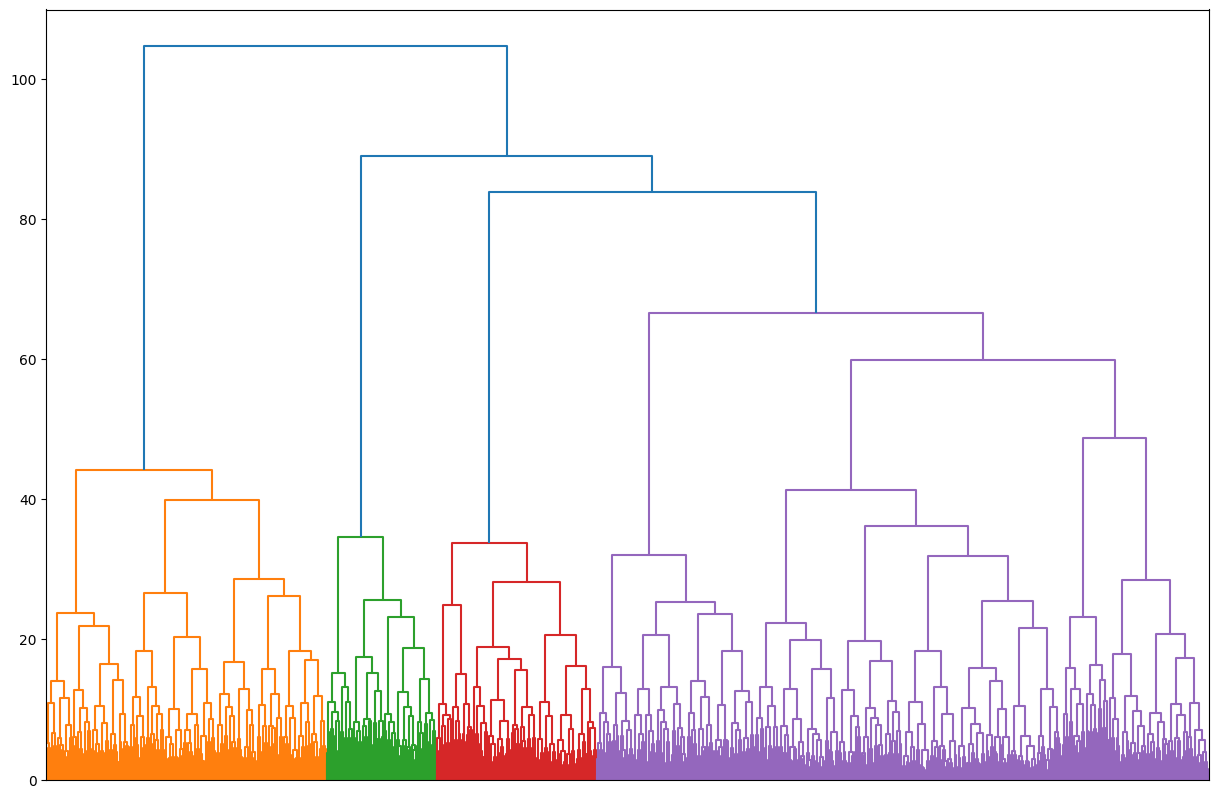

In [36]:
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, orientation='top', no_labels=True)

In [37]:
km = KMeans(n_clusters=5, random_state=5858)
km.fit(X_cluster)

KMeans(n_clusters=5, random_state=5858)

In [38]:
print(davies_bouldin_score(X_cluster, km.labels_))

2.4842863145660923


In [39]:
df['cluster_labels'] = km.labels_

In [40]:
df

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_labels
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,1
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,1
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,4
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,3
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0,3
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1,2
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0,3
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0,4


In [41]:
df_cluster_group = df.groupby('cluster_labels').mean().sort_values('churn', ascending=False)
df_cluster_group

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_labels,,,,,,,,,,,,,,
2,0.474860,0.802607,0.000000,0.072626,0.910615,1.709497,0.284916,28.082868,127.288346,1.648976,2.066108,1.311582,1.052220,0.588454
4,0.508095,0.731009,1.000000,0.418431,0.915318,2.128269,0.262765,28.422167,126.077505,1.985056,2.722291,1.448070,1.248356,0.429639
0,0.558195,0.882423,0.195962,0.172209,0.897862,2.095012,0.495249,30.179335,165.075175,1.992874,5.266033,2.762940,2.768075,0.058195
1,0.566164,0.954774,0.752094,0.574539,0.865997,10.522613,0.643216,29.845896,167.295245,9.710218,4.852596,1.133164,1.114321,0.040201
3,0.460526,0.904971,0.774854,0.485380,0.918129,10.429825,0.483918,30.005848,162.219932,9.431287,4.624269,2.838809,2.835854,0.016082


En orden los cluster por tasa de canselacion de mayor amenor son 2, 4, 0, 1 y 3.

Las características de contrac period, age, y life time, parecen tener una relación más fuerte con la cancelación

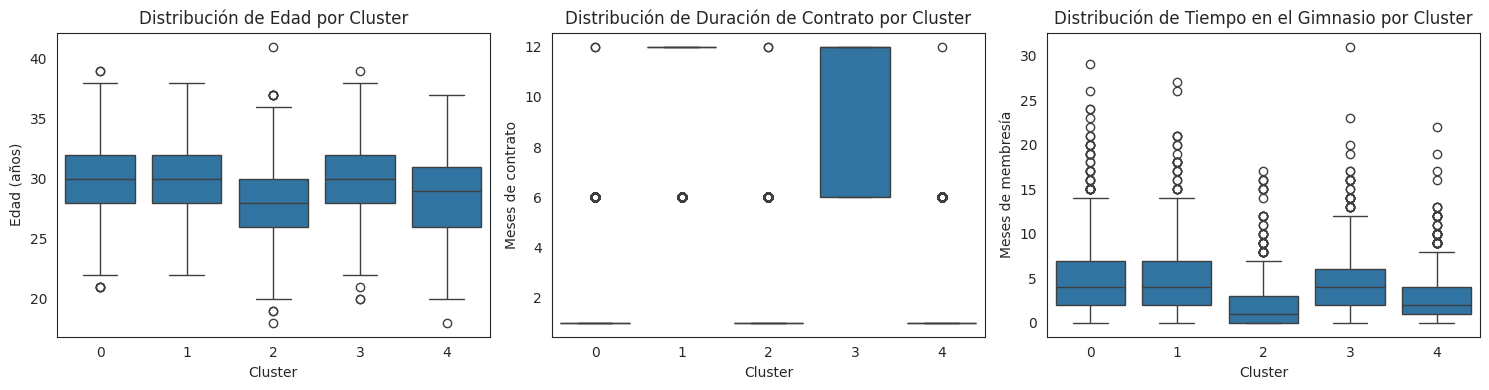

In [42]:
f = plt.figure(figsize=(15, 4))
gs = f.add_gridspec(1, 3)

# Boxplot 1: Edad por Cluster
with sns.axes_style("white"):
    ax = f.add_subplot(gs[0, 0])
    sns.boxplot(x='cluster_labels', y='age', data=df)
    plt.title('Distribución de Edad por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Edad (años)')

# Boxplot 2: Duración de contrato por Cluster
with sns.axes_style("white"):
    ax = f.add_subplot(gs[0, 1])
    sns.boxplot(x='cluster_labels', y='contract_period', data=df)
    plt.title('Distribución de Duración de Contrato por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Meses de contrato')

# Boxplot 3: Tiempo en el gimnasio por Cluster
with sns.axes_style("white"):
    ax = f.add_subplot(gs[0, 2])
    sns.boxplot(x='cluster_labels', y='lifetime', data=df)
    plt.title('Distribución de Tiempo en el Gimnasio por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Meses de membresía')

f.tight_layout()
plt.show()

Podemos ver como los cluster son las edades más bajas con los que más cancelan.

Los cluster donde el periodo de contrato era menor son los que tiene menor tasa de retencion.

Menor tiempo en el gimnasio genera más cancelacion.


In [43]:
churn_rate = df_cluster_group['churn'] * 100
churn_rate

cluster_labels
2    58.845438
4    42.963885
0     5.819477
1     4.020101
3     1.608187
Name: churn, dtype: float64

los cluster 2 y 4 son los mas propensos a cancelar y grupos 0, 1 y 3 son sumamente leales

# Concluciones

Modelos de predicción:

Aun que ambos modelos parecen ser lo suficientemente buenos el modelo que mejor nos funciona en este caso es el de Logistic Regression. En este caso un Recall mas alto es mas efectivo ya que intentamos retener a los clientes.


Cluster: 

Los datos que más están relacionados con la cancelación con la edad, la duración del contrato y el tiempo que el cliente pasa en las instalaciones.


Recomendaciones: 

Nos conviene atraer a clientes mayores de 30 años ya que son más propensos a quedarse.

Hacer ofertas rebajas por un periodo mayor de contrato también servirá para la retención del cliente.

Mejorar el ambiente de las instalaciones para que el cliente se sienta cómodo puede hacer que este pase mas tiempo en ellas.